# Basic Analytics

This notebook extracts and merges data from the database, computes standard evaluation metrics (accuracy, confusion matrix, and classification report), and performs some initial exploratory data analysis.

It uses data from three tables:

- **expected_results:** Contains the expected (target) routing information for each message.
- **actual_results:** Contains the routing outcome predicted by your model.
- **messages:** Contains the generated messages (the input texts).

Ensure that the database connection has been set up (by running the `01_Database_Connection_Setup.ipynb` notebook) so that the engine variable is available.

In [8]:
import pandas as pd
import warnings
from sqlalchemy import create_engine, text
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Retrieve the stored connection string and recreate the engine
%store -r db_uri
engine = create_engine(db_uri)
print("Engine created from db_uri.")

expected_df = pd.read_sql("SELECT * FROM expected_results", engine)
actual_df = pd.read_sql("SELECT * FROM actual_results", engine)
messages_df = pd.read_sql("SELECT * FROM messages", engine)

print("Expected Results Table:")
display(expected_df.head())

print("Actual Results Table:")
display(actual_df.head())

print("Messages Table (first 5 rows):")
display(messages_df.head())



Engine created from db_uri.
Expected Results Table:


,message_id,expected_label
0,1,PAYMENTS
1,2,PAYMENTS
2,3,PAYMENTS
3,4,PAYMENTS
4,5,PAYMENTS


Actual Results Table:


,message_id,model_version,predicted_label,confidence,classification_date
0,301,1.0.0,PAYMENTS,1.00,2025-04-12 17:22:05.670219
1,302,1.0.0,PAYMENTS,1.00,2025-04-12 17:22:05.768444
2,303,1.0.0,PAYMENTS,1.00,2025-04-12 17:22:05.870194
3,304,1.0.0,PAYMENTS,1.00,2025-04-12 17:22:05.969554
4,305,1.0.0,PAYMENTS,0.99,2025-04-12 17:22:06.073924


Messages Table (first 5 rows):


,message_id,template_id,param_id,generated_text,created_at
0,1,1,1,{1:F01BANKBEBBAXXX0000000000}{2:I103BANKDEFFXX...,2025-04-12 17:20:42.022043
1,2,1,1,{1:F01BANKBEBBAXXX0000000000}{2:I103BANKDEFFXX...,2025-04-12 17:20:42.196485
2,3,1,1,{1:F01BANKBEBBAXXX0000000000}{2:I103BANKDEFFXX...,2025-04-12 17:20:42.349430
3,4,1,1,{1:F01BANKBEBBAXXX0000000000}{2:I103BANKDEFFXX...,2025-04-12 17:20:42.504904
4,5,1,1,{1:F01BANKBEBBAXXX0000000000}{2:I103BANKDEFFXX...,2025-04-12 17:20:42.665263


### Merging Data and Computing Standard Metrics

We will merge the three tables based on the key (`message_id`). The merge sequence is as follows:

1. Merge **expected_results** and **actual_results** on `message_id`.
2. Merge the result with the **messages** table to add the generated message text. (We assume the message text column in the messages table is named `generated_text`. If not, adjust accordingly.)

In [32]:
merged_df = pd.merge(expected_df, actual_df, on='message_id', how='inner')

if 'generated_text' not in messages_df.columns:
    print("Note: 'generated_text' column not found in messages_df. Check your messages table.")
else:
    merged_df = pd.merge(merged_df, messages_df[['message_id', 'generated_text']], on='message_id', how='left')

print("Merged Data (first 5 rows):")
display(merged_df.head())

Merged Data (first 5 rows):


,message_id,expected_label,model_version,predicted_label,confidence,classification_date,generated_text
0,301,PAYMENTS,1.0.0,PAYMENTS,1.00,2025-04-12 17:22:05.670219,{1:F01BANKBEBBAXXX0000000000}{2:I103BANKDEFFXX...
1,302,PAYMENTS,1.0.0,PAYMENTS,1.00,2025-04-12 17:22:05.768444,{1:F01BANKBEBBAXXX0000000000}{2:I103BANKDEFFXX...
2,303,PAYMENTS,1.0.0,PAYMENTS,1.00,2025-04-12 17:22:05.870194,{1:F01BANKBEBBAXXX0000000000}{2:I103BANKDEFFXX...
3,304,PAYMENTS,1.0.0,PAYMENTS,1.00,2025-04-12 17:22:05.969554,{1:F01BANKBEBBAXXX0000000000}{2:I103BANKDEFFXX...
4,305,PAYMENTS,1.0.0,PAYMENTS,0.99,2025-04-12 17:22:06.073924,{1:F01BANKBEBBAXXX0000000000}{2:I103BANKDEFFXX...


### Basic Metrics: Cases, Correct Predictions, and Accuracy

In this section, we determine:

- **`total_cases`**: The total number of rows in `merged_df` (i.e., the number of messages under analysis).
- **`correct_predictions`**: How many predictions match their expected labels.
- **`accuracy`**: The ratio of correct predictions to total cases, expressed as a percentage.

Printing these values provides a high-level overview of the models performance:
1. **Total cases** gives context on how many samples were tested.
2. **Correct predictions** shows how often the model's guess aligns with reality.
3. **Accuracy** reveals the overall success

In [10]:
merged_df['match'] = merged_df['expected_label'].str.upper() == merged_df['predicted_label'].str.upper()

total_cases = merged_df.shape[0]
correct_predictions = merged_df['match'].sum()
accuracy = correct_predictions / total_cases if total_cases > 0 else 0

print(f"Total cases compared: {total_cases}")
print(f"Correct predictions: {correct_predictions}")
print(f"Accuracy: {accuracy:.2%}")

Total cases compared: 99
Correct predictions: 99
Accuracy: 100.00%


### Evaluation Metrics and Confidence Statistics

In this section, we perform an analysis of our model’s performance by:
- **Confusion Matrix**: Displays the distribution of true versus predicted labels that helps us identify common misclassifications.
- **Classification Report**: Provides per-class precision, recall, and F1 scores, that gave us a detailed view of the model’s performance on each label.
- **Label Counts**: Shows the frequency of each expected label in the dataset.
- **Confidence Statistics by Label**: For each predicted label, we calculate the mean, standard deviation, minimum, and maximum confidence scores. This can show us how confident the model is for each class.


In [20]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = merged_df['expected_label'].str.upper()
y_pred = merged_df['predicted_label'].str.upper()

mc = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(mc)

report = classification_report(y_true, y_pred, zero_division=0)
print("\nClassification Report:")
print(report)

labels = sorted(merged_df['expected_label'].unique())
print("Label counts:")
print(merged_df['expected_label'].value_counts())
print()

conf_stats = {}
for label in labels:
    mask = merged_df['predicted_label'] == label
    conf_values = merged_df.loc[mask, 'confidence']
    conf_stats[label] = {
        'mean': conf_values.mean() if len(conf_values) > 0 else 0,
        'std': conf_values.std() if len(conf_values) > 0 else 0,
        'min': conf_values.min() if len(conf_values) > 0 else 0,
        'max': conf_values.max() if len(conf_values) > 0 else 0
    }

class_f1_scores = {}
lines = report.split('\n')
for line in lines[2:-5]:
    if line.strip():
        parts = line.split()
        if len(parts) >= 5:
            label = parts[0]
            f1 = float(parts[3])
            class_f1_scores[label] = f1

min_f1 = min(class_f1_scores.values()) if class_f1_scores else 0

min_confidence = merged_df['confidence'].min()



Confusion Matrix:
[[33  0  0]
 [ 0 33  0]
 [ 0  0 33]]

Classification Report:
              precision    recall  f1-score   support

    PAYMENTS       1.00      1.00      1.00        33
   REPORTING       1.00      1.00      1.00        33
    TREASURY       1.00      1.00      1.00        33

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Label counts:
expected_label
PAYMENTS     33
TREASURY     33
REPORTING    33
Name: count, dtype: int64



In this section, we calculate the distribution of model predictions. The match column is a boolean value that indicates whether the predicted label matches the expected label (True for correct predictions, False for incorrect ones).


Prediction counts:
match
True    99
Name: count, dtype: int64


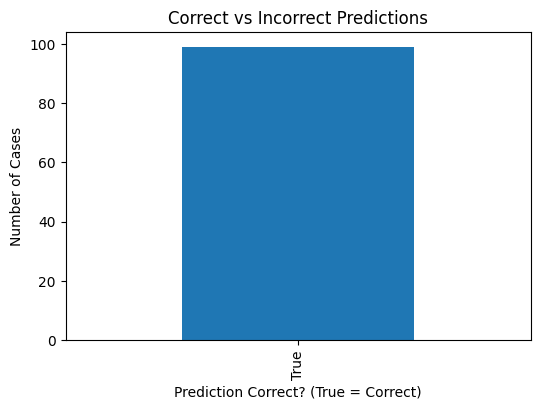

In [21]:
import matplotlib.pyplot as plt

prediction_counts = merged_df['match'].value_counts()
print("\nPrediction counts:")
print(prediction_counts)

plt.figure(figsize=(6,4))
prediction_counts.plot(kind='bar')
plt.title('Correct vs Incorrect Predictions')
plt.xlabel('Prediction Correct? (True = Correct)')
plt.ylabel('Number of Cases')
plt.show()

In [31]:
# Store the merged DataFrame for use in subsequent notebooks
%store merged_df

%store accuracy
%store mc
%store conf_stats
%store labels
%store merged_df
%store min_confidence
%store min_f1
%store model_version
%store report
%store total_cases

# Please update version of your model
model_version = "1.0.0"
%store model_version

Stored 'merged_df' (DataFrame)
Stored 'accuracy' (float64)
Stored 'mc' (ndarray)
Stored 'conf_stats' (dict)
Stored 'labels' (list)
Stored 'merged_df' (DataFrame)
Stored 'min_confidence' (float64)
Stored 'min_f1' (float)
Stored 'model_version' (str)
Stored 'report' (str)
Stored 'total_cases' (int)
Stored 'model_version' (str)


## Conclusion

This notebook has:

- Loaded data from the **expected_results**, **actual_results**, and **messages** tables.
- Merged them using the common key (`message_id`) to include the generated message text.
- Computed standard metrics (accuracy, confusion matrix, and a classification report).
- Performed initial exploratory data analysis (e.g., a bar plot of correct vs. incorrect predictions).

The merged DataFrame, `merged_df`, is stored for use in subsequent analysis notebooks.